In [49]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

from corecomposition import build_catalog, measure_radius, build, analyze
import wdphoto
import configparser

G = 6.674e-11
mass_sun = 1.9884e30
radius_sun = 6.957e8

In [50]:
catpath = 'elbadry.csv'
confpath = 'data/gold.ini'
outpath = 'data/test.csv'

basecat = Table.read(catpath)
config = configparser.ConfigParser()
config.read(confpath)

['data/gold.ini']

In [51]:
basecat, targets, engine_keys = build(config, basecat)

Building Catalog


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Found 380 WD+MS Wide Binaries

Measuring Radii


100%|██████████| 380/380 [01:16<00:00,  4.98it/s]



Fit Report:
Warwick failed=1.05%
CO_Hrich failed=5.79%
ONe_Hrich failed=3.42%
CO_Hdef failed=1.05%
ONe_Hdef failed=2.11%
Total failed=13.42%
Found 5 High Mass WD+MS Wide Binaries


In [52]:
bands = config['radius']['pyphot_bands'].split(' ')

co_hrich_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hrich'))
co_hdef_model = wdphoto.LaPlataInterpolator(bands, massive_params = ('CO', 'Hdef'))

In [60]:
co_hrich_model.teff_lims

(4800, 79000)

In [89]:
teff = np.linspace(5000, 75000, 5)
logg = np.linspace(8.85, 9.3, 100)

co_hrich_radius = []
co_hrich_mass = []
co_hdef_radius = []
co_hdef_mass = []

for j in range(len(teff)):
    aaaa = [co_hrich_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    co_hrich_mass.append([(10**(logg[i] - 2) * (radius_sun * aaaa[i])**2) / (G * mass_sun) for i in range(len(logg))])
    co_hrich_radius.append(aaaa)

    bbbb = [co_hdef_model.radius_interp(teff[j], logg[i]) for i in range(len(logg))]
    co_hdef_mass.append([(10**(logg[i] - 2) * (radius_sun * bbbb[i])**2) / (G * mass_sun) for i in range(len(logg))])
    co_hdef_radius.append(bbbb)

co_hrich_radius = np.array(co_hrich_radius)
co_hrich_mass = np.array(co_hrich_mass)
co_hdef_radius = np.array(co_hdef_radius)
co_hdef_mass = np.array(co_hdef_mass)

[0.01960784 0.18823529 0.38039216 1.        ]
[0.01960784 0.18823529 0.38039216 1.        ]
[0.01960784 0.18823529 0.38039216 1.        ]
[0.01960784 0.18823529 0.38039216 1.        ]
[0.01960784 0.18823529 0.38039216 1.        ]


Text(0, 0.5, 'Radius $[R_\\odot]$')

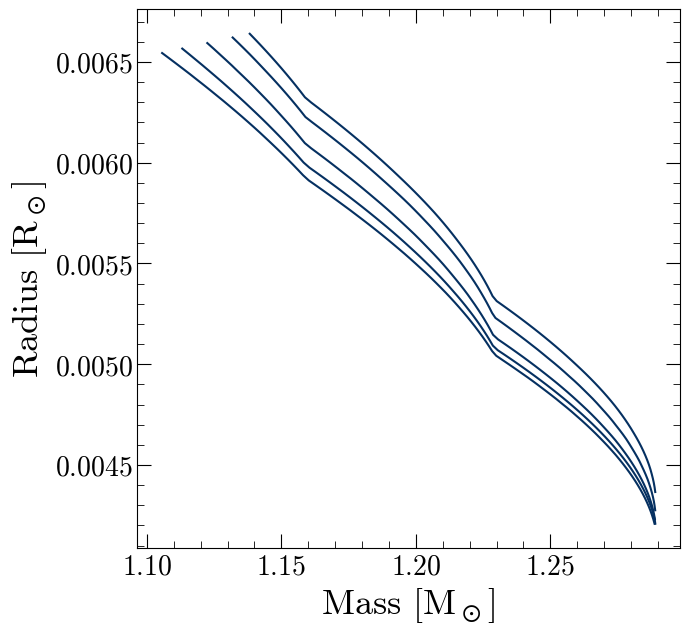

In [94]:
colors = plt.cm.RdBu(teff)

for x, y, c in zip(co_hrich_mass, co_hrich_radius, colors):
    print(c)
    plt.plot(x, y, color=c, linestyle='-')

plt.xlabel(r'Mass $[M_\odot]$')
plt.ylabel(r'Radius $[R_\odot]$')

In [80]:
colors

(0.0196078431372549, 0.18823529411764706, 0.3803921568627451, 1.0)